# Colab Prep
---



Training and Testing will take place in a colab environment with a GPU.

### Data

Relevant files:

*   Text: Train, Test, Classes
*   Annotations: Gun, Knife
*   Images: Gun, Knife
*   Model: 50th Epoch

In [0]:
!wget https://raw.githubusercontent.com/luisra/waldo/master/data/colab/classes.csv
!wget https://raw.githubusercontent.com/luisra/waldo/master/data/colab/gkDataTrain.csv
!wget https://raw.githubusercontent.com/luisra/waldo/master/data/colab/gkDataTest.csv
!wget https://github.com/luisra/waldo/raw/master/model/epochs/resnet50_csv_50.h5
!wget https://github.com/luisra/waldo/raw/master/data/sources/WeaponF.zip && unzip WeaponF
!wget https://github.com/luisra/waldo/raw/master/data/sources/WeaponS.zip && unzip WeaponS
!wget https://github.com/luisra/waldo/raw/master/data/sources/train2014.zip && unzip train2014
!wget https://github.com/luisra/waldo/raw/master/data/sources/val2014.zip && unzip val2014
!wget https://github.com/luisra/waldo/raw/master/data/sources/annotations_trainval2014.zip && unzip annotations_trainval2014  

### Keras



Install.

In [0]:
!pip install -q keras
import keras

### Retinanet

Clone.

In [0]:
!git clone --recursive https://github.com/fizyr/keras-retinanet.git

Install.

In [0]:
!cd keras-retinanet && pip install . --user

Get recommended weights.

In [0]:
!cd keras-retinanet/snapshots && wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5

Build inplace.

In [0]:
!cd keras-retinanet && python setup.py build_ext --inplace

# Train

---

Feed training data into model.
<br><br>
Parameters used:
*   **Weights** - Initial weights that will be used to fine-tune a custom dataset. This will be set to the recommended weights of a model trained on MS COCO with a backbone of Resnet50.
*   **Epochs** - Number of forward and backward passes for all training samples. This will be set to 50.
*   **Steps** - Total number of training samples. This will be set to 11,108.
<br><br>

The loss and classification loss decreased with each passing epoch. After 50, the classification loss was less than 0.1. This model was then evaluated on the test data to measure its performance.

In [0]:
!cd keras-retinanet/keras_retinanet/bin && python train.py --weights /content/keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5 --epochs 50 --steps 11108 --snapshot-path /content csv /content/gkData.csv /content/classes.csv


# Test

---

Convert training model into an inference model.

In [0]:
!cd keras-retinanet/keras_retinanet/bin && python convert_model.py /content/resnet50_csv_50.h5 /content/model50.h5

Feed test data into model.
<br><br>
Relevant parameters:
*   **IoU Threshold** (default) - Value threshold to classify a prediction as a true positive. This will be 0.5.
*   **Score Threshold** (default) - Score threshold to filter detections. This will be 0.05.
*   **Backbone** (default) - Backbone of the model. This will be Resnet50.
*   **Model** - Model to be used. This will be set to the model after the 50th epoch.

In [0]:
!cd keras-retinanet/keras_retinanet/bin && python evaluate.py csv /content/gkDataTest.csv /content/classes.csv /content/model50.h5

Using TensorFlow backend.
W0710 03:31:15.783185 140515220088704 deprecation_wrapper.py:119] From evaluate.py:42: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 03:31:15.783488 140515220088704 deprecation_wrapper.py:119] From evaluate.py:44: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2019-07-10 03:31:15.797439: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-07-10 03:31:15.797623: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2484a00 executing computations on platform Host. Devices:
2019-07-10 03:31:15.797649: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-07-10 03:31:15.799465: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-07-10 03:31:15.924139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful 

Note: Since the average precision for the knife class is only 0.3, the focus will be on the gun class moving forward.

# Metrics
---

Mean Average Precision is a popular metric for measuring the accuracy of object detectors. This takes other metrics into account such as precision, recall, and intersection over union.

### Precision

Precision measures how accurate are the predictions. This translates to

>$P = \frac{TP}{TP + FP}$
<br><br>
Where:
*   TP = True Positive
*   FP = False Positive

For example, the number of gun instances correctly identified divided by the predicted total number of gun instances.

### Recall

Recall measures how good we are at finding the postives

>$R = \frac{TP}{TP + FN}$
<br><br>
Where:
*   TP = True Positive
*   FN = False Negative

For example, the number of knife instances correctly identified divided by the actual total number of knife instances.

### IoU

Intersection over Union measures the overlap between two boundaries.

>$IoU = \frac{AreaOfOverlap}{AreaOfUnion}$

This value is used to classify a prediction as a true positive.



### mAP

In this case, mAP refers to the mean of the average precision between the two classes, gun and knife.
<br><br>
So what's happening in the testing phase?
<br><br>
Predictions are made. These are considered correct for IoU values equal to or greater than 0.5. For each class, the average precision is determined by measuring the area under the precision-recall curve. Finally, the mean average precision is calculated.
<br><br>
Is this the best metric for evaluating videos?
<br><br>
Not necessarily. Since the processing of videos will be done frame by frame, it'd be more valuable (at first) to consider the following:

* Was a detection made at all?
* Was the detection accurate?
* How good is the model at tracking a detected object?





# Prototype
---


Prep.

In [0]:
import sys
sys.path.append('/content/keras-retinanet')
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet

Relevant modules.

In [0]:
from keras_retinanet.utils.image import preprocess_image
from keras_retinanet.utils.image import read_image_bgr
from keras_retinanet.utils.image import resize_image
from keras_retinanet import models
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
import numpy as np
import cv2

Session settings.

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

Known variables.

In [0]:
images = ['png', 'jpg', 'jpeg', 'gif', 'tif', 'tiff']
videos = ['avi', 'flv', 'mp4', 'mov', 'wmv', 'mkv']
classes = {0: 'gun', 1: 'knife'}

model = models.load_model("/content/model50.h5", backbone_name="resnet50")

### Images

Create detection function.

In [0]:
def imgDetect(file, conf): 
  
  ext = file.split('.')[-1]  
  
  if ext in images: #check extension

        # load image and make a copy
        image = read_image_bgr(file)
        image = image[:, :, ::-1].copy()
        output = image.copy()
        
        # prep for network
        image = preprocess_image(image)
        image, scale = resize_image(image)
        image = np.expand_dims(image, axis=0)
        
        # predict
        with sess.as_default():
            with sess.graph.as_default():
                boxes, scores, labels = model.predict_on_batch(image)
                
        # rescale 
        boxes /= scale
        
        for (box, score, label) in zip(boxes[0], scores[0], labels[0]):
            
            if score < float(conf): # check threshold 
                continue
        
            if classes[label] == 'gun': # draw
                
                box = box.astype('int')
                xmin, ymin, xmax, ymax = box
                    
                cv2.rectangle(output, (xmin, ymin), (xmax, ymax), 
                              (0, 255, 0), 2)
                
                cv2.putText(output, classes[label], (xmin, ymin - 10),
                		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # show
        plt.figure(figsize=(12,12))
        plt.imshow(output)
        plt.axis('off')
          
  else:
    return "Not a valid image."

Retrieve samples for testing.

In [0]:
!wget https://github.com/luisra/waldo/raw/master/data/samples/cop.jpg
!wget https://github.com/luisra/waldo/raw/master/data/samples/gunman.jpg

Detect.

Note: The model is better at detecting handguns. Confidence level was reduced to capture both.



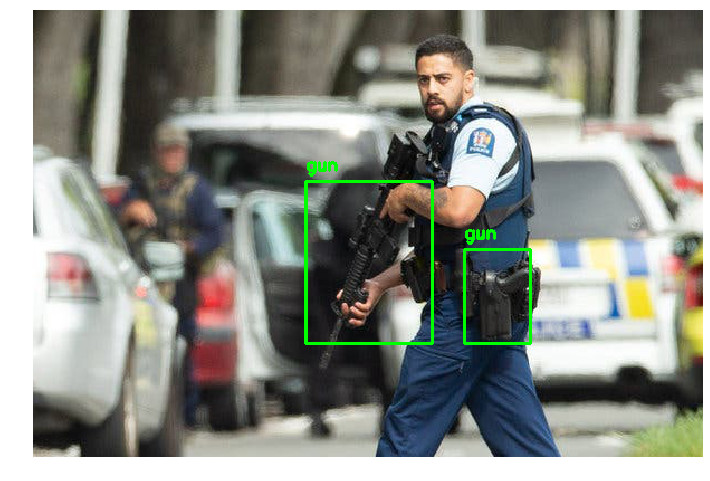

In [0]:
print("Note: The model is better at detecting handguns. Confidence level was reduced to capture both.\n")

imgDetect('/content/cop.jpg', 0.2)

Detect.

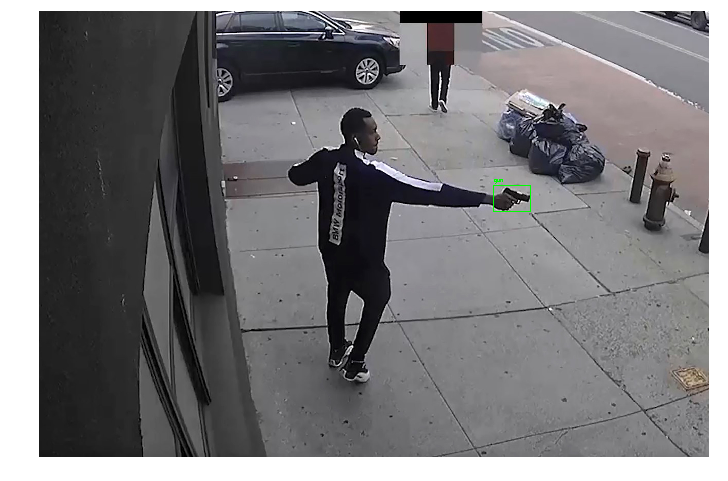

In [0]:
imgDetect('/content/gunman.jpg', 0.7)

### Videos

Create detection function.

In [0]:
def vidDetect(file, conf): 
  
    ext = file.split('.')[-1]
    
    if ext in videos: # check extension
  
        # video prep
        cap = cv2.VideoCapture(file)
        fps = cap.get(cv2.CAP_PROP_FPS)
        writer = None
        c = 0
       
        while True: # process video
            
            ret, frame = cap.read()
           
            if not ret:
                break
           
            c += 1
            bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
       
            # prep for network
            image = preprocess_image(bgr)
            image, scale = resize_image(image)
            image = np.expand_dims(image, axis=0)

            # predict
            with sess.as_default():
                with sess.graph.as_default():
                    boxes, scores, labels = model.predict_on_batch(image)

            # rescale 
            boxes /= scale

            for (box, score, label) in zip(boxes[0], scores[0], labels[0]):

                if score < float(conf): # check threshold 
                    continue

                if classes[label] == 'gun': # draw

                    box = box.astype('int')
                    xmin, ymin, xmax, ymax = box

                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), 
                                  (0, 255, 0), 2)

                    cv2.putText(frame, classes[label], (xmin, ymin - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
            # write
            if writer is None:
                fourcc = cv2.VideoWriter_fourcc(*'MP4V')
                writer = cv2.VideoWriter('/content/output.mp4', fourcc, fps,
                                         (frame.shape[1], frame.shape[0]))
   
            if writer is not None:
                writer.write(frame)
        
        # cleanup
        cap.release()
       
        if writer is not None:
            writer.release()
            
    else:
      return "Not a valid video."

Retrieve sample for testing.

In [0]:
!wget https://github.com/luisra/waldo/raw/master/data/samples/guns.mp4

Detect.

In [0]:
vidDetect('/content/guns.mp4',0.7)

Display output.

In [0]:
print("Note: Output was uploaded in order to be displayed.\n")

from IPython.display import HTML

HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/zxenHpdwPuY" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")


Note: Output was uploaded in order to be displayed.



Note the jitter and lack of sound. These two issues will be addressed moving forward.